In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import R2Score, MeanAbsoluteError, MeanAbsolutePercentageError, Accuracy
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import StandardScaler

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [8]:
# Charger votre jeu de données
data = pd.read_csv('C:/Users/utilisateur/2024/E1/data.csv')


In [9]:
# Assuming `data` is your pandas DataFrame
if 'ID' in data.columns:
    data.drop('ID', axis=1, inplace=True)


In [10]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])


# Split data into training and testing sets
X_train, X_test = train_test_split(numeric_data, test_size=0.2, random_state=42)
X_test_original = X_test.copy()

# Introduce missing values in 10% of the test data
np.random.seed(42)
mask = np.random.rand(*X_test.shape) < 0.1
X_test[mask] = np.nan




In [11]:
X_test_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2558 entries, 10190 to 7810
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     2558 non-null   int64  
 1   Levy                      2558 non-null   int64  
 2   Engine volume             2558 non-null   float64
 3   Mileage(km)               2558 non-null   int64  
 4   Cylinders                 2558 non-null   float64
 5   Airbags                   2558 non-null   int64  
 6   Fuel type_CNG             2558 non-null   int64  
 7   Fuel type_Diesel          2558 non-null   int64  
 8   Fuel type_Hybrid          2558 non-null   int64  
 9   Fuel type_Hydrogen        2558 non-null   int64  
 10  Fuel type_LPG             2558 non-null   int64  
 11  Fuel type_Petrol          2558 non-null   int64  
 12  Fuel type_Plug-in Hybrid  2558 non-null   int64  
dtypes: float64(2), int64(11)
memory usage: 279.8 KB


In [12]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


# The resulting X_train_scaled and X_test_scaled are now normalized versions of the original data
X_train_scaled, X_test_scaled

(          Price      Levy  Engine volume  Mileage(km)  Cylinders   Airbags  \
 0     -0.845987  1.071662       0.134644    -0.034712  -0.476364  1.139605   
 1     -0.111090  0.175028       1.363200    -0.034886   1.199591  1.139605   
 2     -1.213435 -0.019359       0.246331    -0.035940  -0.476364  1.139605   
 3     -0.241697 -1.033327      -0.312103    -0.031891  -0.476364  1.139605   
 4      0.607455 -1.033327       0.134644    -0.035940  -2.990297  1.139605   
 ...         ...       ...            ...          ...        ...       ...   
 10226 -0.209097  1.185493      -0.870538    -0.034796  -0.476364  1.139605   
 10227  0.574855 -1.033327      -0.535477    -0.033458  -0.476364  0.684350   
 10228  1.326104 -1.033327       0.246331    -0.034426  -0.476364  1.139605   
 10229 -1.090953  0.810728       1.363200    -0.033363   1.199591  1.139605   
 10230 -1.026587 -1.033327      -0.758851    -0.033088  -0.476364 -1.136668   
 
        Fuel type_CNG  Fuel type_Diesel  Fuel type

In [13]:
# Confirm that missing values were introduced
print("Missing values in X_test:", X_test.isna().sum().sum())

Missing values in X_test: 3349


In [14]:
print("values in X_test:", X_test.notna().sum().sum())

values in X_test: 29905


In [15]:

class CustomImputerModel:
    def __init__(self):
        self.models = {}
        self.column_types = {}  # Pour stocker les types de chaque colonne
        self.min_values = {}    # Pour stocker les valeurs minimales
        self.max_values = {}    # Pour stocker les valeurs maximales

    def fit(self, X_ref, X_train, validation_split=0.2):
        # Utiliser X_ref pour récupérer les types de colonnes, min et max
        for col in X_ref.columns:
            self.column_types[col] = X_ref[col].dtype
            self.min_values[col] = X_ref[col].min()
            self.max_values[col] = X_ref[col].max()

        # Utiliser X_train pour l'entraînement
        for col in X_train.columns:
            features = X_train.drop(col, axis=1)
            target = X_train[col]

            non_missing = target.notna()
            features_non_missing = features[non_missing]
            target_non_missing = target[non_missing]

            # Créer un modèle de réseau de neurones simple
            model = Sequential([
                Input(shape=(features_non_missing.shape[1],)),
                Dense(128, activation='relu'),
                Dense(128, activation='relu'),
                Dense(64, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer='adam', loss='mean_squared_error',metrics=[R2Score(), Accuracy(), MeanAbsolutePercentageError(), MeanAbsoluteError()])

            # Entraîner le modèle
            model.fit(features_non_missing, target_non_missing, epochs=50, batch_size=32, verbose=0, validation_split=validation_split)
            self.models[col] = model
            history = model.fit(features_non_missing, target_non_missing, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
        return history
    
    def predict(self, X):
        X_imputed = X.copy()

        for col in X.columns:
            missing = X_imputed[col].isna()
            if missing.any():
                X_missing = X_imputed[missing].drop(col, axis=1)
                predictions = self.models[col].predict(X_missing).flatten()

                # Convertir les prédictions au type original
                if self.column_types[col].kind in ['i', 'u']:
                    predictions = np.round(predictions).astype(self.column_types[col])
                elif self.column_types[col].kind == 'f':
                    predictions = predictions.astype(self.column_types[col])
                
                # Limiter les prédictions aux plages de valeurs minimales et maximales
                predictions = np.clip(predictions, self.min_values[col], self.max_values[col])

                # Assurer que toutes les valeurs sont positives pour les types numériques
                if self.column_types[col].kind in ['i', 'u', 'f']:
                    predictions = np.maximum(predictions, 0)

                X_imputed.loc[missing, col] = predictions

        return X_imputed


In [16]:
# Initialize and fit the custom model
model = CustomImputerModel()
# model.fit(numeric_data, X_train_scaled, validation_split=0.2)



In [17]:
history = model.fit(numeric_data, X_train_scaled) 


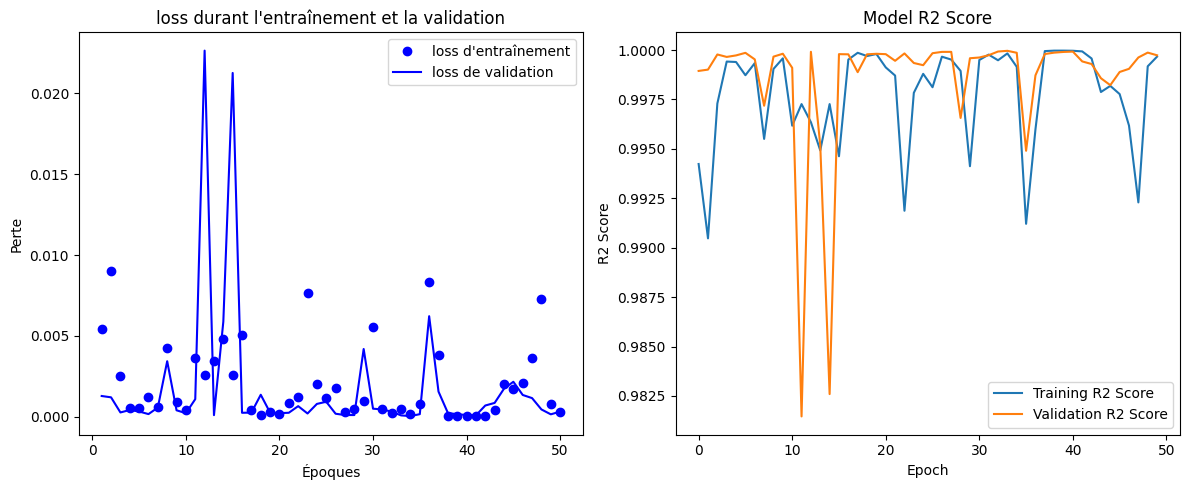

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Courbe de perte
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='loss d\'entraînement')
plt.plot(epochs, val_loss, 'b', label='loss de validation')
plt.title('loss durant l\'entraînement et la validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(history.history['r2_score'], label='Training R2 Score') # Adjust the key if necessary
plt.plot(history.history['val_r2_score'], label='Validation R2 Score') # Adjust the key if necessary
plt.title('Model R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [20]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title('Learning curve - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    

    # Plot R2 score if it exists
    if 'r2_score' in history.history and 'val_r2_score' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['r2_score'], 'bo', label='Training R2 Score')
        plt.plot(epochs, history.history['val_r2_score'], 'b', label='Validation R2 Score')
        plt.title('Learning curve - R2 Score')
        plt.xlabel('Epochs')
        plt.ylabel('R2 Score')
        plt.legend()

    plt.tight_layout()
    plt.show()


Courbes d'apprentissage pour la colonne : Price


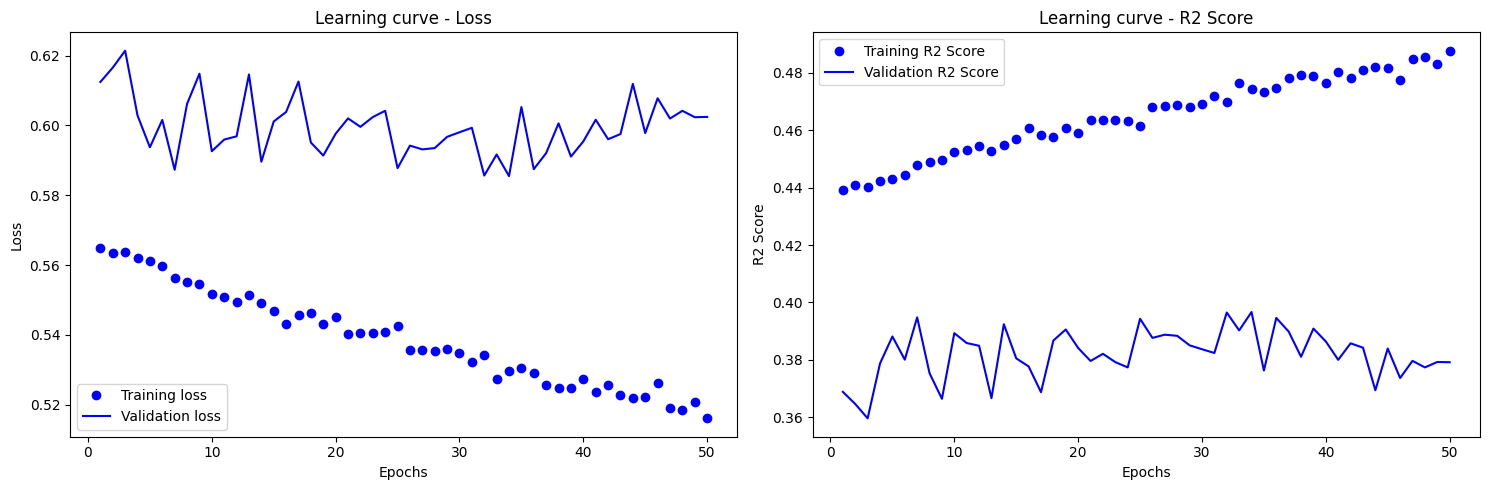

Courbes d'apprentissage pour la colonne : Levy


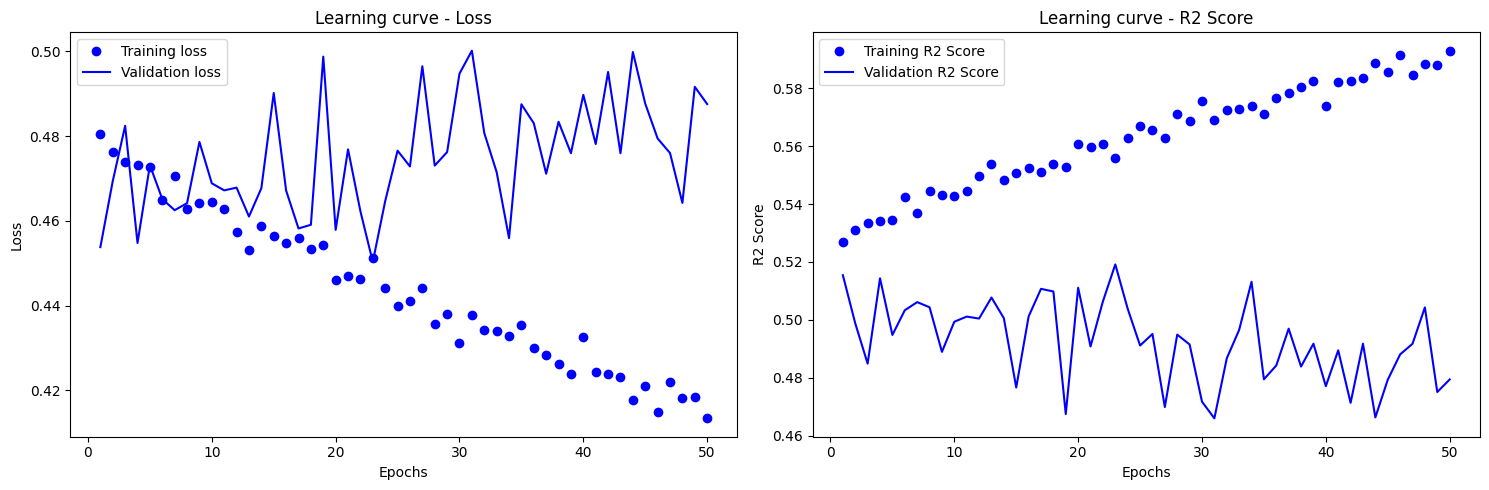

Courbes d'apprentissage pour la colonne : Engine volume


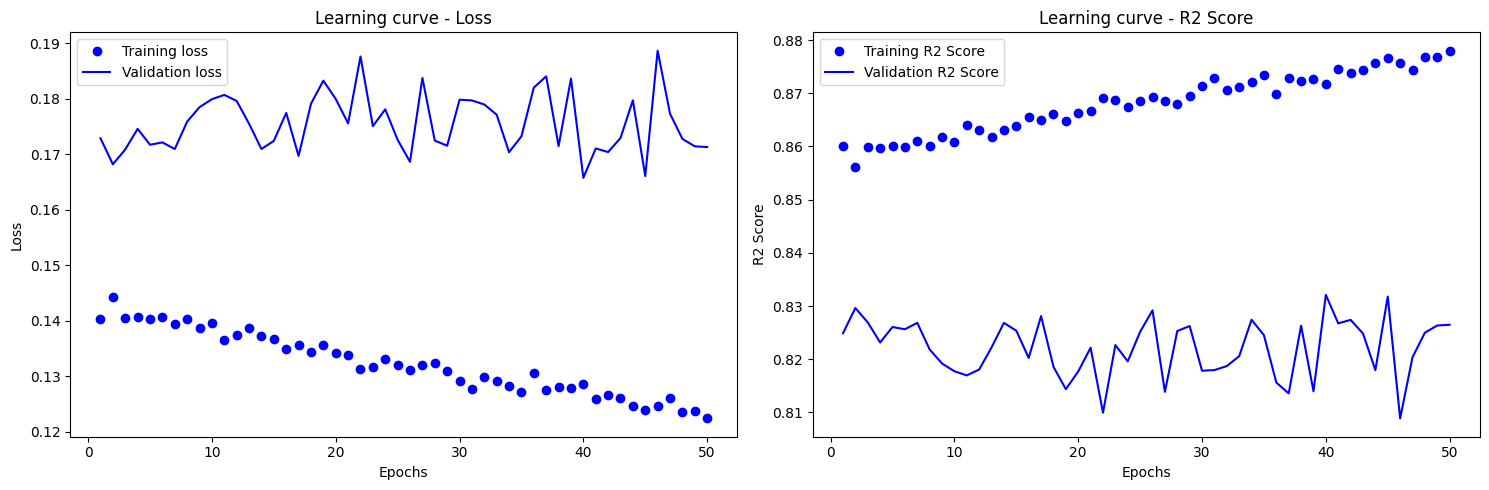

Courbes d'apprentissage pour la colonne : Mileage(km)


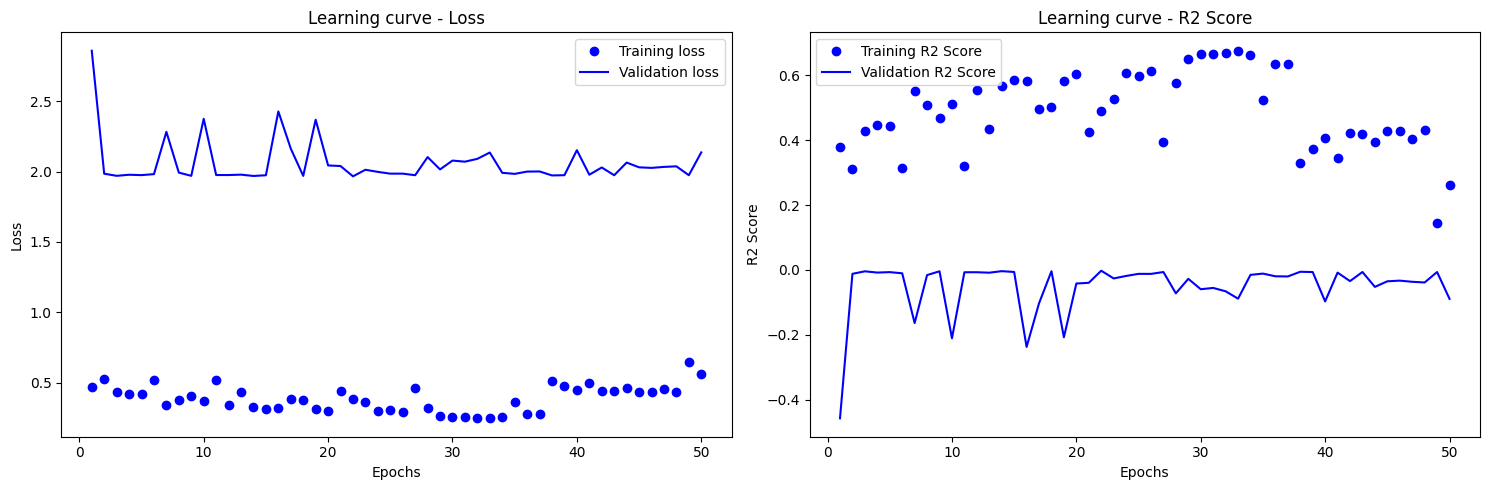

Courbes d'apprentissage pour la colonne : Cylinders


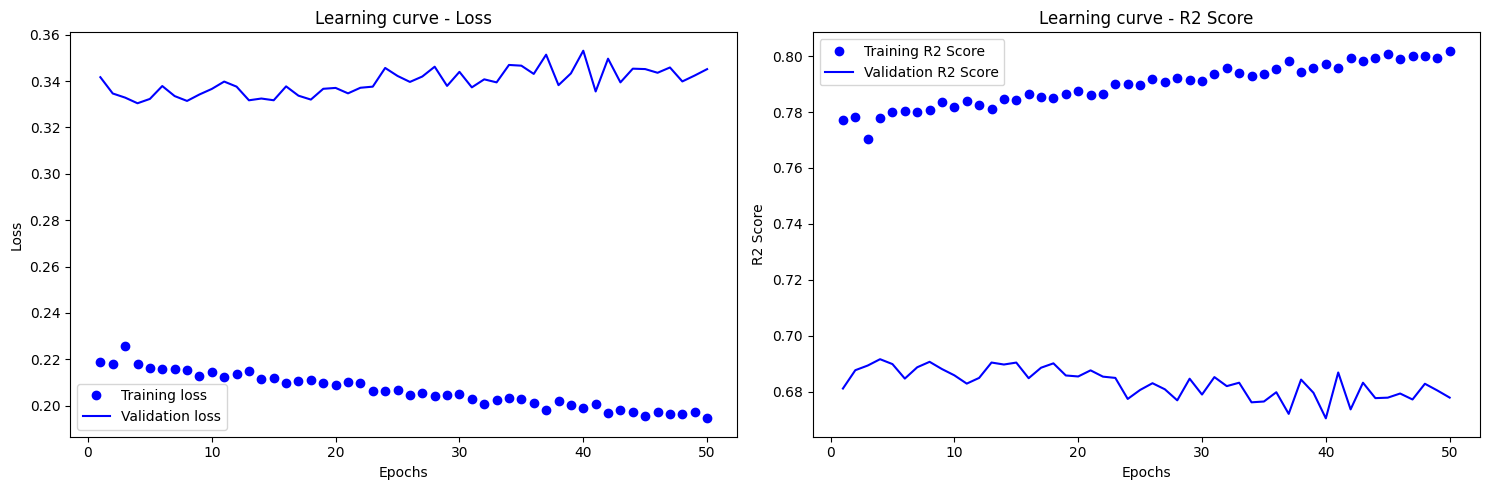

Courbes d'apprentissage pour la colonne : Airbags


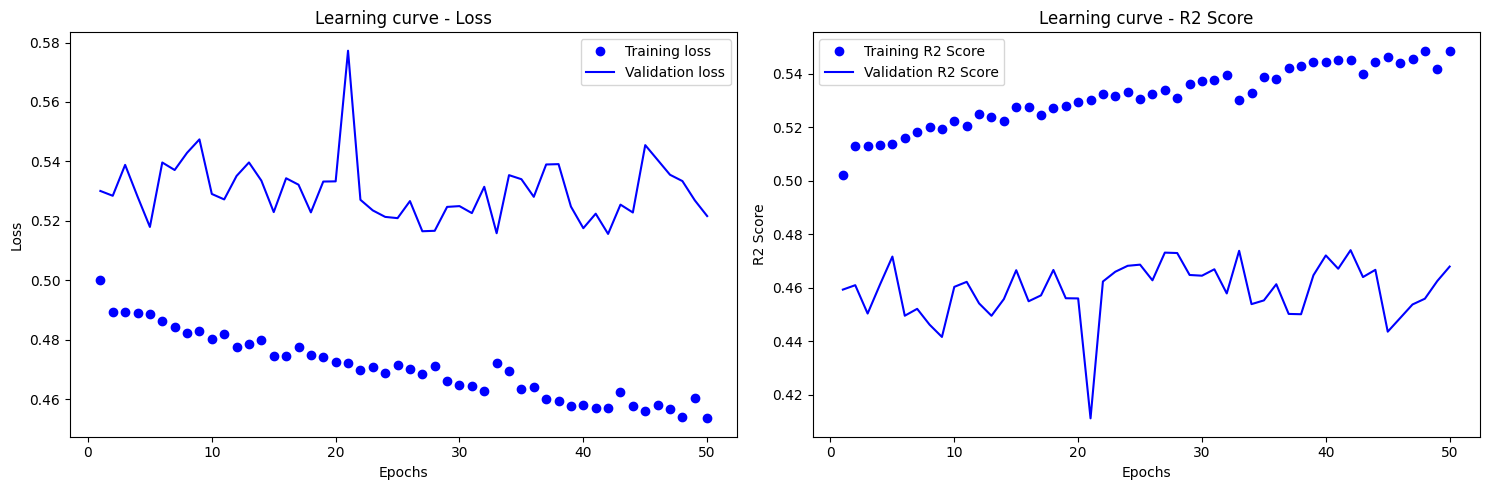

Courbes d'apprentissage pour la colonne : Fuel type_CNG


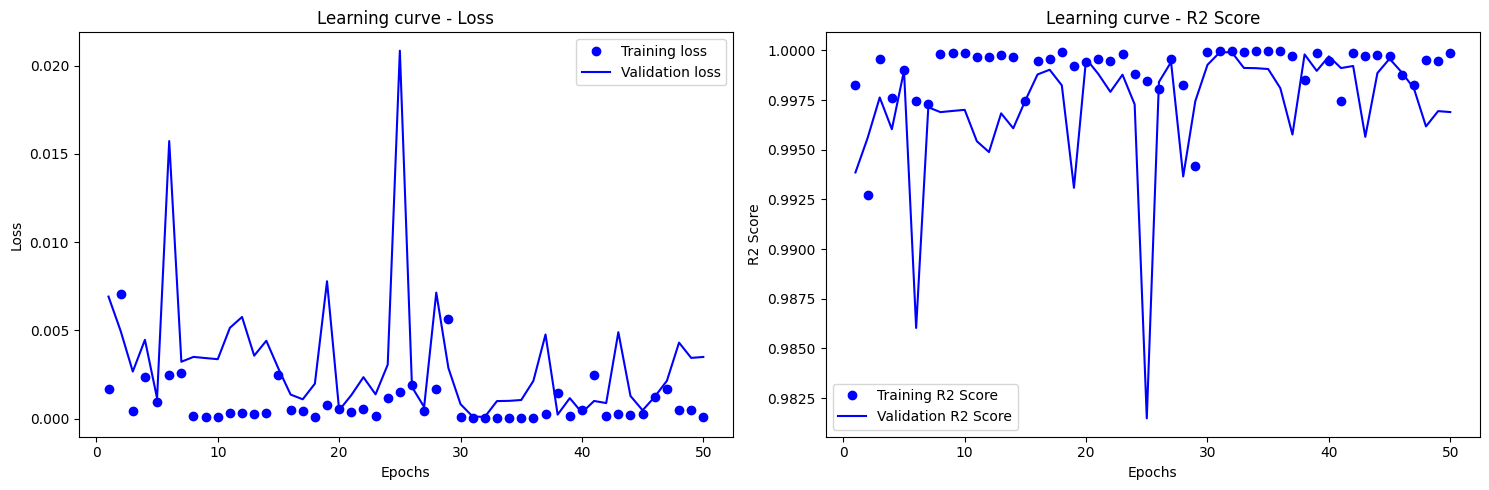

Courbes d'apprentissage pour la colonne : Fuel type_Diesel


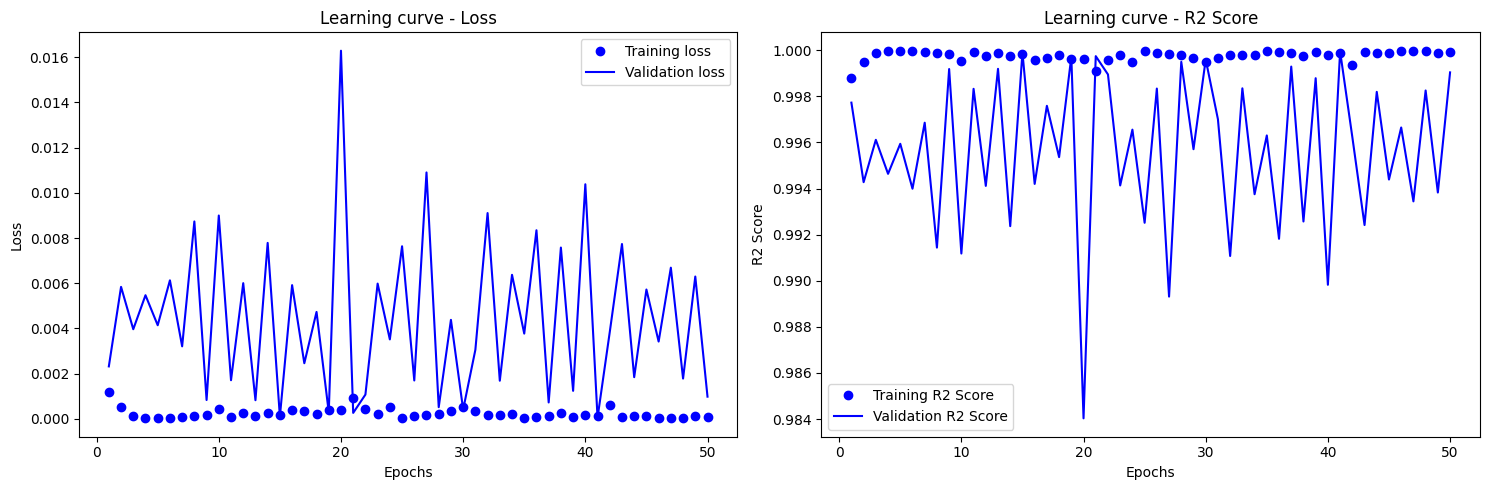

Courbes d'apprentissage pour la colonne : Fuel type_Hybrid


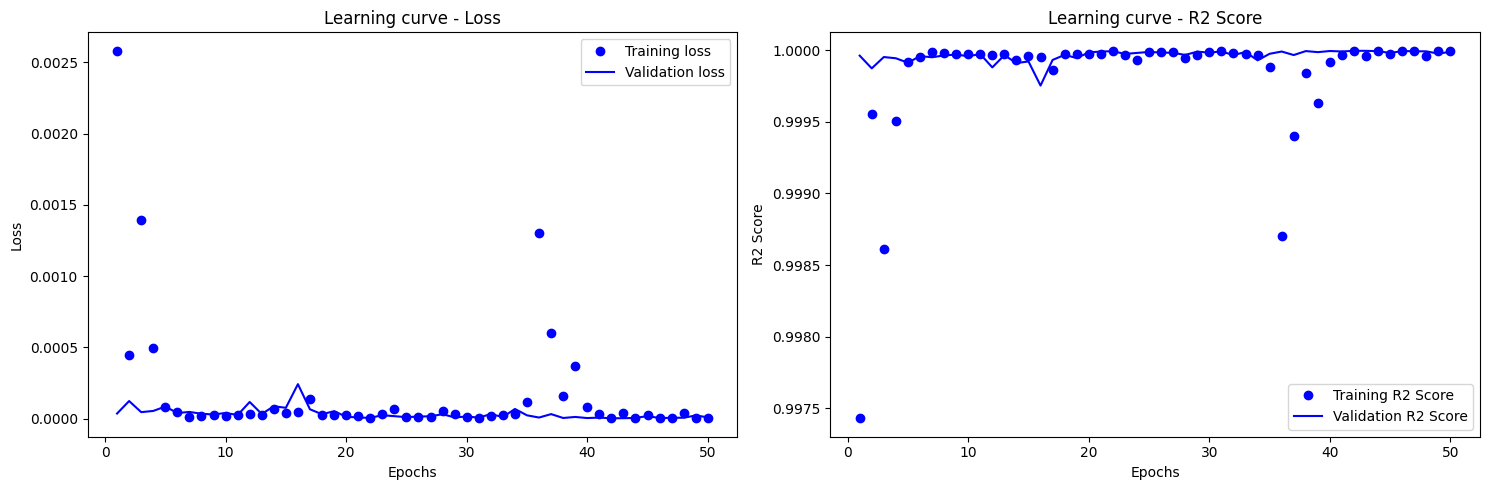

Courbes d'apprentissage pour la colonne : Fuel type_Hydrogen


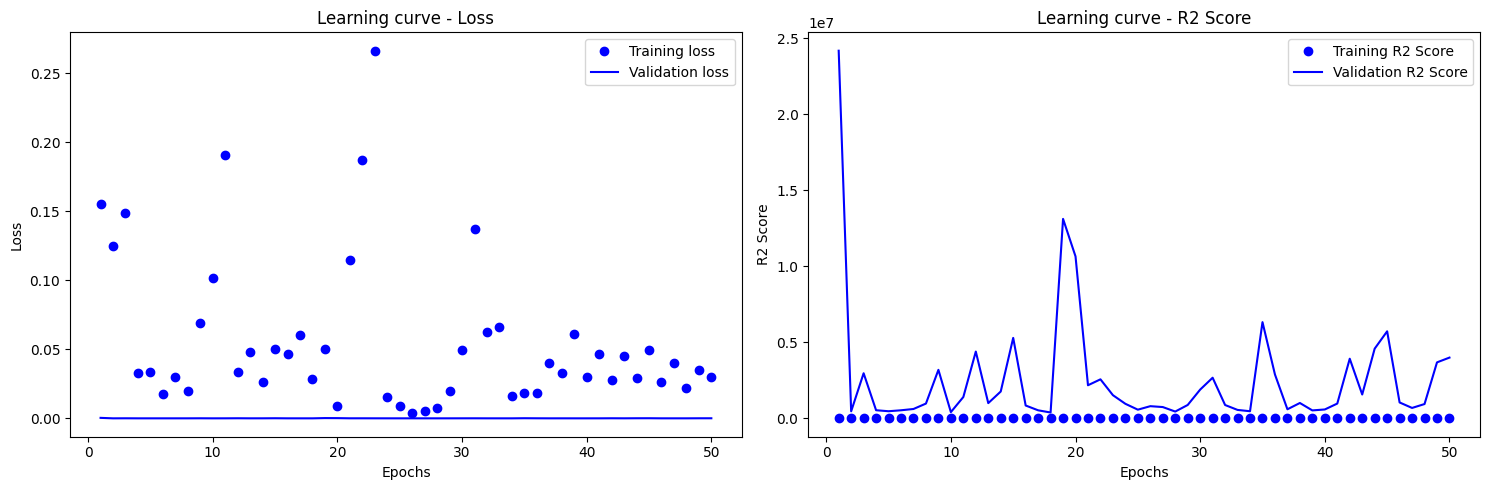

Courbes d'apprentissage pour la colonne : Fuel type_LPG


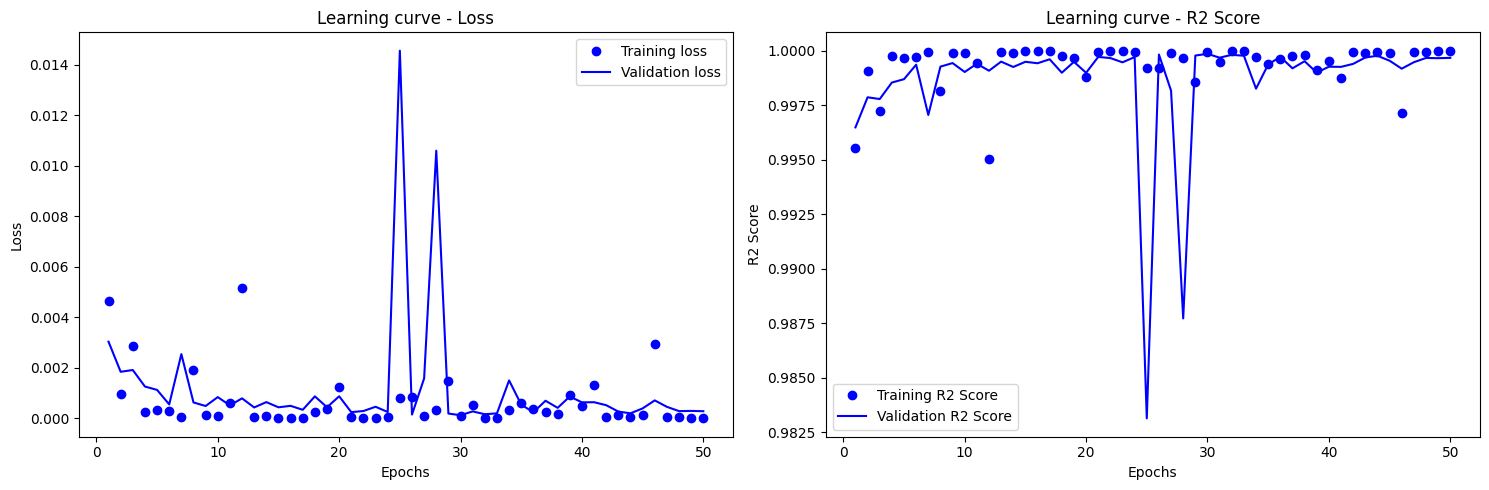

Courbes d'apprentissage pour la colonne : Fuel type_Petrol


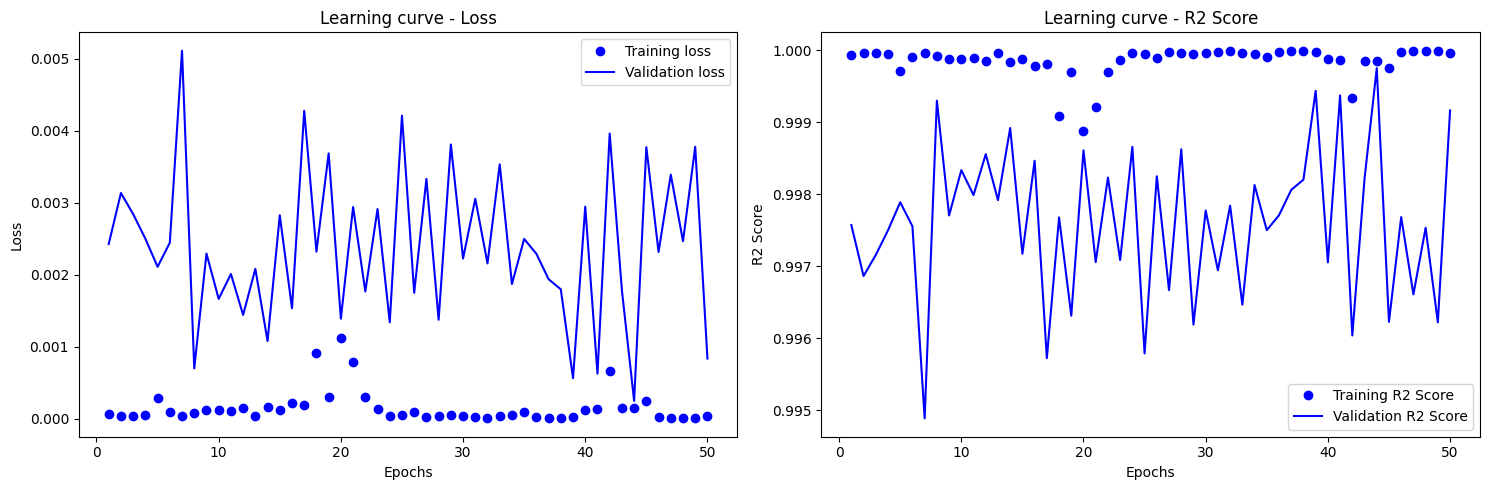

Courbes d'apprentissage pour la colonne : Fuel type_Plug-in Hybrid


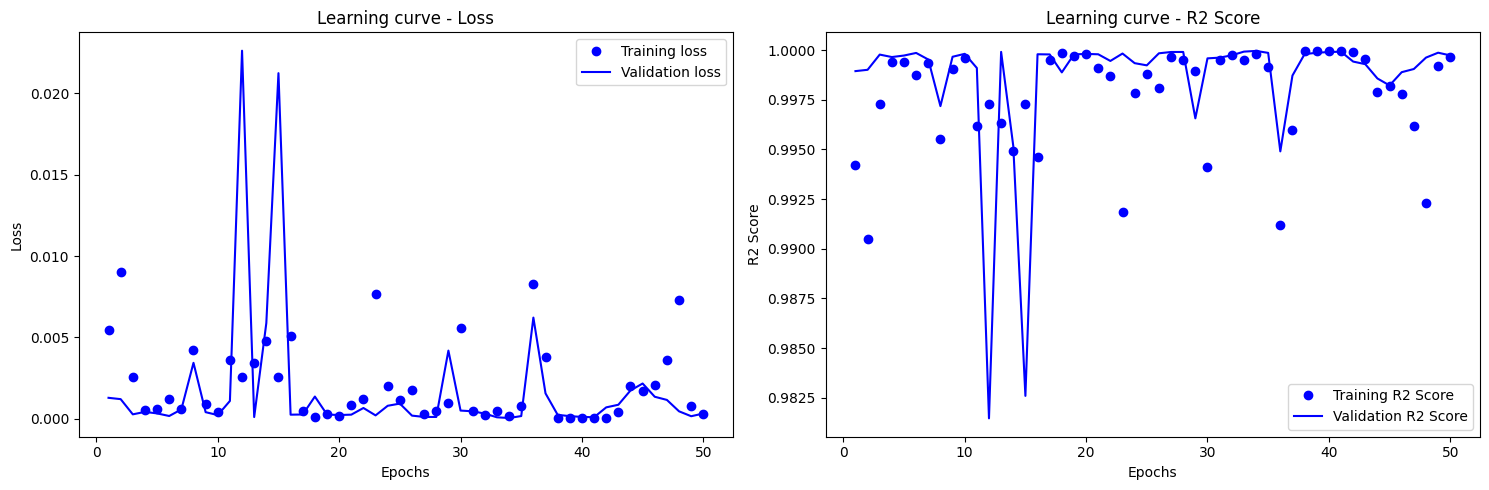

In [22]:
# Tracer les courbes d'apprentissage pour chaque colonne
for col in X_train.columns:
    history = model.models[col].history
    print(f"Courbes d'apprentissage pour la colonne : {col}")
    plot_learning_curves(history)
    plt.show()




In [24]:
# Impute missing values in the test set
X_test_imputed = model.predict(X_test)

# Show the first few rows of the imputed test set
X_test_imputed.head()

9/9 [==============================] - 0s 2ms/step


,Price,Levy,Engine volume,Mileage(km),Cylinders,Airbags,Fuel type_CNG,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_Hydrogen,Fuel type_LPG,Fuel type_Petrol,Fuel type_Plug-in Hybrid
10190,2509.0,1399.0,3.5,315270.0,6.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1923,34811.0,690.0,3.5,0.0,6.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10622,2038.0,353.0,1.8,4.0,4.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
10193,784.0,779.0,2.5,0.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1989,20491.0,730.0,1.6,50051.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_test_imputed = scaler.inverse_transform(X_test_imputed)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)


In [26]:
 X_test_imputed

,Price,Levy,Engine volume,Mileage(km),Cylinders,Airbags,Fuel type_CNG,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_Hydrogen,Fuel type_LPG,Fuel type_Petrol,Fuel type_Plug-in Hybrid
0,2.410214e+07,799452.982417,5.413206,1.790609e+13,11.728564,59.711303,0.186684,0.152576,0.68950,0.000098,0.017594,0.544815,0.004398
1,3.342449e+08,394596.788188,5.413206,2.041260e+06,11.728564,59.711303,0.026390,0.152576,0.68950,0.000098,0.017594,0.544815,0.004398
2,1.957990e+07,202161.615473,3.891093,2.292255e+08,9.341865,59.711303,0.186684,0.152576,0.68950,0.000098,0.017594,0.544815,0.004398
3,7.539813e+06,445417.946561,4.517846,2.041260e+06,9.341865,59.711303,0.026390,0.152576,0.25413,0.000098,0.017594,1.042802,0.004398
4,1.967536e+08,417437.758244,3.712021,2.842701e+12,5.761818,24.566134,0.026390,0.512153,0.25413,0.000098,0.017594,0.544815,0.004398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2553,4.066446e+07,590.054736,4.428310,8.519612e+10,9.341865,6.993549,0.026390,0.152576,0.25413,0.000098,0.017594,1.042802,0.004398
2554,2.304831e+08,492812.959426,2.368981,4.106470e+12,9.341865,24.566134,0.026390,0.512153,0.25413,0.000098,0.017594,0.544815,0.004398
2555,2.499354e+08,590.054736,2.368981,8.451255e+12,9.341865,42.138719,0.026390,0.152576,0.25413,0.000098,0.017594,0.544815,0.004398
2556,2.348805e+08,590.054736,2.368981,5.111647e+12,9.341865,42.138719,0.026390,0.152576,0.25413,0.000098,0.017594,0.544815,0.070573


In [27]:
# Debugging: Check for NaN values after imputation
nan_count_after = X_test_imputed.isna().sum().sum()
print("NaN count after imputation:", nan_count_after)

NaN count after imputation: 0


In [28]:
perc=  ((3589-nan_count_after)*100)/3589
perc

100.0

In [32]:
# comp = X_test_original.compare(X_test_imputed)
# Calculate and compare statistics
stats_original = X_test_original.describe().T[['mean', 'std']]
stats_imputed = X_test_imputed.describe().T[['mean', 'std']]

comparison_stats = pd.concat([stats_original, stats_imputed], axis=1, keys=['Original', 'Imputed'])
comparison_stats

Original                     Imputed  \
                                   mean           std          mean   
Price                      12132.337373  9.508743e+03  1.062412e+08   
Levy                         594.023065  5.722423e+02  3.765868e+05   
Engine volume                  2.297263  9.123412e-01  4.255363e+00   
Mileage(km)               909233.082877  2.681538e+07  5.089903e+13   
Cylinders                      4.582486  1.165951e+00  9.711660e+00   
Airbags                        6.927287  4.417163e+00  3.490669e+01   
Fuel type_CNG                  0.026974  1.620397e-01  3.980037e-02   
Fuel type_Diesel               0.160672  3.673003e-01  2.244067e-01   
Fuel type_Hybrid               0.241204  4.278975e-01  3.480798e-01   
Fuel type_Hydrogen             0.000000  0.000000e+00  4.030558e-04   
Fuel type_LPG                  0.019156  1.370985e-01  2.257892e-02   
Fuel type_Petrol               0.546521  4.979285e-01  7.877735e-01   
Fuel type_Plug-in Hybrid       0.005473  7.379160e-02  7.709704e-03   

                                        
                                   std  
Price                     9.352914e+07  
Levy                      4.978646e+05  
Engine volume             1.141671e+00  
Mileage(km)               1.523030e+15  
Cylinders                 2.036800e+00  
Airbags                   2.047649e+01  
Fuel type_CNG             4.439002e-02  
Fuel type_Diesel          1.437959e-01  
Fuel type_Hybrid          1.791343e-01  
Fuel type_Hydrogen        1.710629e-03  
Fuel type_LPG             2.511591e-02  
Fuel type_Petrol          2.489693e-01  
Fuel type_Plug-in Hybrid  1.443054e-02

In [ ]:
comp.head(50)